In [1]:
import numpy as np

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, RepeatVector, TimeDistributed
#from keras.datasets import imdb
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
from keras.utils import plot_model
import pydot
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
max_features = 20000
# cut texts after this number of words
# (among top max_features most common words)
maxlen = 100
batch_size = 32

print('Loading data...')
mat_contents = sio.loadmat('Train/peipei.mat')
x_train = mat_contents['x']
y_train = mat_contents['y']

x_train = x_train[1:21,:,:]
y_train = y_train[1:21,:,:]

# get dimensions
m, nt, npitch = x_train.shape
ny = y_train.shape[2]
print('m ,nt, npitch = ', str(x_train.shape))
print('ny = ' + str(ny))
print(y_train.shape)
nbatch = 10 # number of training examples 
nepoch = 500

Loading data...
m ,nt, npitch =  (20, 100, 176)
ny = 443
(20, 100, 443)


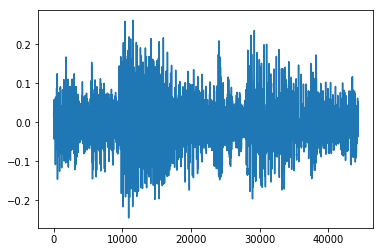

In [12]:
y_vec = y_train[5,:,:].reshape((nt*ny,1))
plt.plot(y_vec)

In [13]:
def bidi_LSTM(m, nt, npitch, ny):
    # define bidirectional LSTM configuration
    n_neurons_encoder = 128 # refers to size of Memory matrices (can be anything)
    #n_neurons_decoder = 10
    #intermediate_layer = 500;

    # create LSTM
    model = Sequential()
    # encoder
    model.add(Bidirectional(LSTM(n_neurons_encoder,return_sequences = True),input_shape=(nt, npitch)))
    model.add(Bidirectional(LSTM(n_neurons_encoder,return_sequences = True),batch_input_shape = (n_neurons_encoder, n_neurons_encoder)))
    #model.add(Bidirectional(LSTM(n_neurons_encoder,return_sequences = True),batch_input_shape = (nbatch,n_neurons_encoder,n_neurons_encoder)))
    model.add(TimeDistributed(Dense(ny, activation=None)))
    
#     model.add(RepeatVector(intermediate_layer))
#     # decoder
#     model.add(Bidirectional(LSTM(n_neurons_decoder, return_sequences = True), input_shape=(ny/2,n_neurons_decoder)))
#     model.add(Bidirectional(LSTM(n_neurons_decoder)))
#     model.add(RepeatVector(ny))
#     model.add(Bidirectional(LSTM(n_neurons_decoder, return_sequences = True), input_shape=(ny,n_neurons_decoder)))
#     model.add(TimeDistributed(Dense(1)))

    return model

In [14]:
model = bidi_LSTM(m, nt, npitch, ny)
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 100, 256)          312320    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 256)          394240    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 443)          113851    
Total params: 820,411
Trainable params: 820,411
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
#print(model.summary())
# train LSTM
model.fit(x_train, y_train, epochs=nepoch, batch_size=nbatch)
# evaluate

Epoch 1/500
20/20 [==============================] - 2s 81ms/step - loss: 0.0085
Epoch 2/500
20/20 [==============================] - 1s 49ms/step - loss: 0.0080
Epoch 3/500
20/20 [==============================] - 1s 49ms/step - loss: 0.0078
Epoch 4/500
20/20 [==============================] - 1s 50ms/step - loss: 0.0077
Epoch 5/500
20/20 [==============================] - 1s 50ms/step - loss: 0.0077
Epoch 6/500
20/20 [==============================] - 1s 50ms/step - loss: 0.0076
Epoch 7/500
20/20 [==============================] - 1s 50ms/step - loss: 0.0076
Epoch 8/500
20/20 [==============================] - 1s 48ms/step - loss: 0.0076
Epoch 9/500
20/20 [==============================] - 1s 50ms/step - loss: 0.0076
Epoch 10/500
20/20 [==============================] - 1s 54ms/step - loss: 0.0075
Epoch 11/500
20/20 [==============================] - 1s 53ms/step - loss: 0.0075
Epoch 12/500
20/20 [==============================] - 1s 53ms/step - loss: 0.0075
Epoch 13/500
20/20 [=====

20/20 [==============================] - 1s 54ms/step - loss: 0.0062
Epoch 102/500
20/20 [==============================] - 1s 55ms/step - loss: 0.0061
Epoch 103/500
20/20 [==============================] - 1s 56ms/step - loss: 0.0061
Epoch 104/500
20/20 [==============================] - 1s 53ms/step - loss: 0.0061
Epoch 105/500
20/20 [==============================] - 1s 55ms/step - loss: 0.0060
Epoch 106/500
20/20 [==============================] - 1s 53ms/step - loss: 0.0060
Epoch 107/500
20/20 [==============================] - 1s 52ms/step - loss: 0.0059
Epoch 108/500
20/20 [==============================] - 1s 54ms/step - loss: 0.0059
Epoch 109/500
20/20 [==============================] - 1s 56ms/step - loss: 0.0058
Epoch 110/500
20/20 [==============================] - 1s 51ms/step - loss: 0.0058
Epoch 111/500
20/20 [==============================] - 1s 49ms/step - loss: 0.0057
Epoch 112/500
20/20 [==============================] - 1s 51ms/step - loss: 0.0057
Epoch 113/500
20/2

20/20 [==============================] - 1s 49ms/step - loss: 0.0048
Epoch 200/500
20/20 [==============================] - 1s 48ms/step - loss: 0.0048
Epoch 201/500
20/20 [==============================] - 1s 52ms/step - loss: 0.0048
Epoch 202/500
20/20 [==============================] - 1s 52ms/step - loss: 0.0048
Epoch 203/500
20/20 [==============================] - 1s 53ms/step - loss: 0.0048
Epoch 204/500
20/20 [==============================] - 1s 52ms/step - loss: 0.0047
Epoch 205/500
20/20 [==============================] - 1s 49ms/step - loss: 0.0047
Epoch 206/500
20/20 [==============================] - 1s 49ms/step - loss: 0.0047
Epoch 207/500
20/20 [==============================] - 1s 51ms/step - loss: 0.0047
Epoch 208/500
20/20 [==============================] - 1s 51ms/step - loss: 0.0047
Epoch 209/500
20/20 [==============================] - 1s 50ms/step - loss: 0.0047
Epoch 210/500
20/20 [==============================] - 1s 48ms/step - loss: 0.0047
Epoch 211/500
20/2

20/20 [==============================] - 1s 49ms/step - loss: 0.0040
Epoch 298/500
20/20 [==============================] - 1s 48ms/step - loss: 0.0040
Epoch 299/500
20/20 [==============================] - 1s 49ms/step - loss: 0.0039
Epoch 300/500
20/20 [==============================] - 1s 48ms/step - loss: 0.0039
Epoch 301/500
20/20 [==============================] - 1s 48ms/step - loss: 0.0039
Epoch 302/500
20/20 [==============================] - 1s 49ms/step - loss: 0.0039
Epoch 303/500
20/20 [==============================] - 1s 49ms/step - loss: 0.0039
Epoch 304/500
20/20 [==============================] - 1s 48ms/step - loss: 0.0039
Epoch 305/500
20/20 [==============================] - 1s 47ms/step - loss: 0.0038
Epoch 306/500
20/20 [==============================] - 1s 49ms/step - loss: 0.0038
Epoch 307/500
20/20 [==============================] - 1s 48ms/step - loss: 0.0038
Epoch 308/500
20/20 [==============================] - 1s 48ms/step - loss: 0.0038
Epoch 309/500
20/2

20/20 [==============================] - 1s 49ms/step - loss: 0.0027
Epoch 396/500
20/20 [==============================] - 1s 50ms/step - loss: 0.0027
Epoch 397/500
20/20 [==============================] - 1s 49ms/step - loss: 0.0027
Epoch 398/500
20/20 [==============================] - 1s 48ms/step - loss: 0.0027
Epoch 399/500
20/20 [==============================] - 1s 48ms/step - loss: 0.0027
Epoch 400/500
20/20 [==============================] - 1s 50ms/step - loss: 0.0027
Epoch 401/500
20/20 [==============================] - 1s 48ms/step - loss: 0.0027
Epoch 402/500
20/20 [==============================] - 1s 49ms/step - loss: 0.0027
Epoch 403/500
20/20 [==============================] - 1s 49ms/step - loss: 0.0027
Epoch 404/500
20/20 [==============================] - 1s 49ms/step - loss: 0.0027
Epoch 405/500
20/20 [==============================] - 1s 49ms/step - loss: 0.0027
Epoch 406/500
20/20 [==============================] - 1s 49ms/step - loss: 0.0027
Epoch 407/500
20/2

20/20 [==============================] - 1s 49ms/step - loss: 0.0021
Epoch 494/500
20/20 [==============================] - 1s 48ms/step - loss: 0.0021
Epoch 495/500
20/20 [==============================] - 1s 50ms/step - loss: 0.0021
Epoch 496/500
20/20 [==============================] - 1s 48ms/step - loss: 0.0021
Epoch 497/500
20/20 [==============================] - 1s 49ms/step - loss: 0.0021
Epoch 498/500
20/20 [==============================] - 1s 48ms/step - loss: 0.0021
Epoch 499/500
20/20 [==============================] - 1s 48ms/step - loss: 0.0020
Epoch 500/500
20/20 [==============================] - 1s 48ms/step - loss: 0.0020


In [41]:
x_train = mat_contents['x']
y_train = mat_contents['y']

x_train = x_train[21:41,:,:]
y_train = y_train[21:41,:,:]

# x_train = x_train[1:21,:,:]
# y_train = y_train[1:21,:,:]

from scipy.io.wavfile import write

y_train_flattened = y_train.reshape(y_train.size,1)
scaled = np.int16(y_train_flattened/np.max(np.abs(y_train_flattened))*32767)
write('y_train.mp3',44100,scaled)

# evaluate 
y_pred = model.predict(x_train, batch_size=nbatch)

y_pred_flattened = y_pred.reshape(y_pred.size,1)
scaled = np.int16(y_pred_flattened/np.max(np.abs(y_pred_flattened))*32767)
write('y_pred.mp3',44100,scaled)

sio.savemat('y_train.mat',mdict={'y_train':y_train})
sio.savemat('y_pred.mat',mdict={'y_pred': y_pred})
#print(result)

nmodel = 1
filepath = 'Models/run' + str(nmodel)
model.save(filepath)

(20, 100, 443)


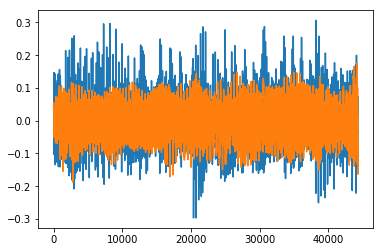

In [42]:
print(result.shape)
y_train_vec = y_train[5,:,:].reshape((nt*ny,1))
y_pred_vec = y_pred[5,:,:].reshape((nt*ny,1))

plt.figure(1)
plt.plot(y_train_vec)
plt.plot(y_pred_vec)

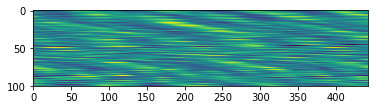

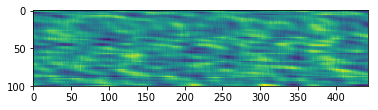

In [43]:
plt.figure(2)
plt.imshow(y_train[5,:,:])
plt.figure(3)
plt.imshow(y_pred[5,:,:])

In [ ]:
print(np.sum((result.flatten()-Y_train.flatten())**2)/44100)
print(result.flatten()[10:15])